# Inverse Schrödinger problem solved using DP (fig. 7.4)
## Author: Julian Arnold 

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import jax
from jax.config import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import grad, value_and_grad

In [58]:
# Import custom font
import matplotlib.font_manager as fm

path = r'../fonts/Hero New Regular.otf' # for text only
path_abc = r'../fonts/Hero New Medium.otf' # for (a), (b), etc.
custom_font = fm.FontProperties(fname=path, size=14)
custom_font_abc = fm.FontProperties(fname=path_abc, size=16)

In [59]:
# Import colors (e.g., as 1D and dictionary)
import pickle

# Use colors as a dictionary
infile = open('../colors/colors_dict.pkl','rb')
colors_dict = pickle.load(infile)
infile.close()

# Import 1D array of colors
infile = open('../colors/colors_1D.pkl','rb')
colors_1D = pickle.load(infile)
infile.close()


In [60]:
# Seaborn style set
sns.set(style="whitegrid", rc={'figure.figsize':(5.25,3.375)}) # in inches
sns.set_style("whitegrid", {'grid.linestyle': 'dashed', "grid.color": "0.5", 'axes.edgecolor': '.1'})
np.random.seed(42)

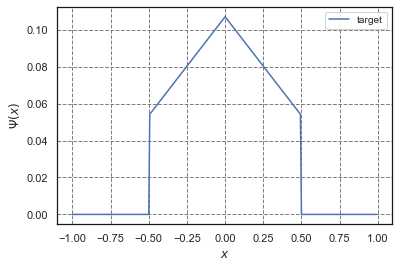

In [26]:
xmin, xmax, N = -1., 1., 300
xmesh = jnp.linspace(xmin, xmax, N, endpoint=False)                                                                                                             
target = np.zeros(N)                                                    
idx = (np.abs(xmesh) < 0.5)                                             
target[idx] = 1. - np.abs(xmesh[idx])                              
target /= jnp.linalg.norm(target)

h = (xmax - xmin) / N
K = -0.5/h**2 * (jnp.diag(-2 * jnp.ones(N))
               + jnp.diag(jnp.ones(N - 1), k=1)
               + jnp.diag(jnp.ones(N - 1), k=-1))

def make_loss(K, target):
    def loss_fn(potential): 
        H = K + jnp.diag(potential)
        _, psis = jax.scipy.linalg.eigh(H)
        psi0 = psis[:, 0]
        loss = jnp.abs(psi0**2 - target**2).sum()
        return loss
    return loss_fn

init_potential = 0.5 * xmesh**2
loss_fn = make_loss(K, target)
loss = loss_fn(init_potential)
print("initial loss:", loss)

import scipy.optimize
def value_and_grad_numpy(f):
    def val_grad_f(*args):
        value, grad = value_and_grad(f)(*args)
        return np.array(value), np.array(grad)
    return val_grad_f
results = scipy.optimize.minimize(value_and_grad_numpy(loss_fn), np.array(init_potential),
                                  method="L-BFGS-B", jac=True, options={'gtol': 1e-07})
print("success:", results.success, "\nniterations:", results.nit, "\nfinal loss:", results.fun)

initial loss: 0.3865271435509192
success: True 
niterations: 1616 
final loss: 0.023328090145183254


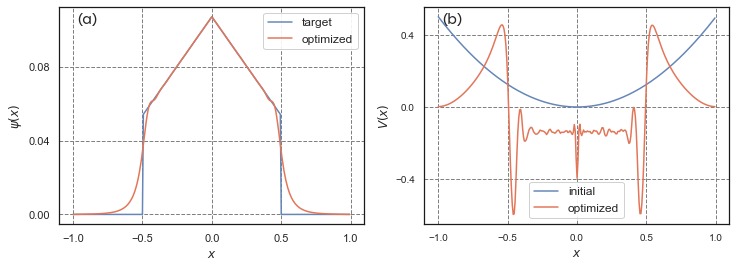

In [56]:
fig, (ax_psi, ax_potential) = plt.subplots(1, 2, figsize=(12, 4))

ax_psi.plot(xmesh, target, label="target", color=colors_dict["blue"]["medium"])
H = K + jnp.diag(results.x)
_, psis = jax.scipy.linalg.eigh(H)
psi0 = psis[:, 0]
ax_psi.plot(xmesh, jnp.abs(psi0), label="optimized", color=colors_dict["orange"]["medium"])
ax_psi.set_xlabel("$x$", size=16, fontproperties=custom_font)
ax_psi.set_ylabel("$\psi\,(x)$", size=16, fontproperties=custom_font)
ax_psi.legend(fontsize = 12, framealpha = 0.9, prop=fm.FontProperties(fname=path, size=14))

ax_potential.plot(xmesh, init_potential, label="initial", color=colors_dict["blue"]["medium"])
ax_potential.plot(xmesh, results.x/300, label="optimized", color=colors_dict["orange"]["medium"])
ax_potential.set_xlabel("$x$", size=12, fontproperties=custom_font)
ax_potential.set_ylabel("$V(x)$", size=12, fontproperties=custom_font)
ax_potential.legend(fontsize = 12, framealpha = 0.9, prop=fm.FontProperties(fname=path, size=14))

ax_psi.text(0.06, 0.925, "(a)", fontsize=15, fontproperties=custom_font_abc,transform=ax_psi.transAxes)
ax_potential.text(0.06, 0.925, "(b)", fontsize=15, fontproperties=custom_font_abc,transform=ax_potential.transAxes)

ax_psi.set_yticks([0.0,0.04,0.08])
ax_psi.set_xticks([-1.0,-0.5,0.0,0.5,1.0])

ax_potential.set_yticks([-0.4,0.0,0.4])
ax_potential.set_xticks([-1.0,-0.5,0.0,0.5,1.0])

plt.tick_params(labelsize=11)

fig.savefig("figure7.4.pdf", bbox_inches='tight')